In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(f"[INFO] importing directory: {dirname}\n")
    with tqdm(total=len(filenames)) as t:
        for filename in filenames:
            t.update(1)

[INFO] importing directory: /kaggle/input



0it [00:00, ?it/s]


[INFO] importing directory: /kaggle/input/flood-area-segmentation



100%|██████████| 1/1 [00:00<00:00, 4104.02it/s]


[INFO] importing directory: /kaggle/input/flood-area-segmentation/Mask



100%|██████████| 290/290 [00:00<00:00, 413161.74it/s]


[INFO] importing directory: /kaggle/input/flood-area-segmentation/Image



100%|██████████| 290/290 [00:00<00:00, 181138.97it/s]


In [2]:
# All important imports

import tensorflow as tf
from keras.models import Model

from tqdm import tqdm
from skimage.color import rgb2gray as rtg
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from skimage.morphology import label
from PIL import Image

from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Reshape
from tensorflow.keras.initializers import glorot_uniform

In [3]:
# Defining basic file paths
imagesPath = "/kaggle/input/flood-area-segmentation/Image"
masksPath = "/kaggle/input/flood-area-segmentation/Mask"

In [4]:
# Extracting file names as 0.jpg

images_ids = next(os.walk(imagesPath))[2]
masks_ids = next(os.walk(masksPath))[2]

In [5]:
# Total images and masks count

print(f"Total images: {len(images_ids)}\nTotal masks: {len(masks_ids)}")

Total images: 290
Total masks: 290


In [6]:
# Creating blank array of the length of image_ids i.e 290, 256, 256, 3

X = np.zeros((len(images_ids), 256, 256, 3), dtype=np.uint8)
Y = np.zeros((len(masks_ids), 256, 256, 1), dtype=np.bool_)

In [7]:
# Resizing the images to 256, 256 and then adding them to the above matrix

print("Resizing training images and masks")
for n, id_ in tqdm(enumerate(images_ids), total=len(images_ids)):
    path = imagesPath + "/" + id_
    img = Image.open(path)
    img = np.array(img)
    img = resize(img, (256, 256, 3), mode="constant", preserve_range=True)
    X[n] = img
    mask = np.zeros((256, 256, 1), dtype=np.bool_)
    mask = imread(masksPath + "/" + id_.split(".")[0] + ".png")
    mask = np.expand_dims(resize(mask, (256, 256), mode="constant", preserve_range=True), axis=-1)
    Y[n] = mask

Resizing training images and masks


100%|██████████| 290/290 [02:04<00:00,  2.34it/s]


In [8]:
# Printing the shape of the data

print(f"X.shape: {X.shape}\nY.shape: {Y.shape}")

X.shape: (290, 256, 256, 3)
Y.shape: (290, 256, 256, 1)


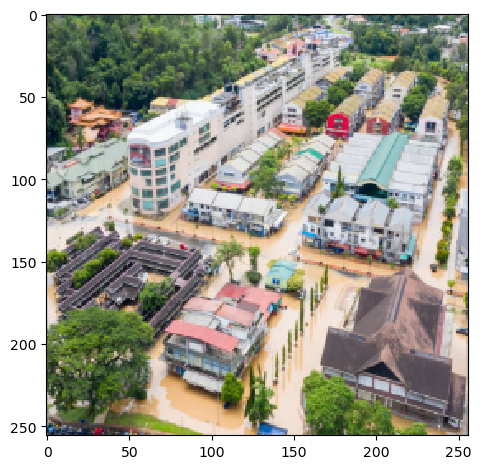

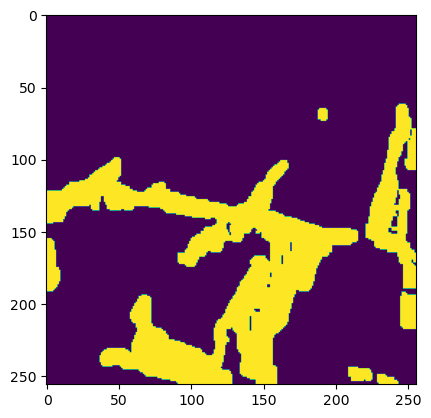

In [9]:
# Plotting random images and their mask

import random
image_x = random.randint(0, len(images_ids))
imshow(X[image_x])
plt.show()
plt.imshow(np.squeeze(Y[image_x]))

In [10]:
# The custom U-Net Architecture

# Input image
input = tf.keras.layers.Input((256, 256, 3))

# reduce image config
s = tf.keras.layers.Lambda(lambda x: x / 256)(input)

# block 1
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation="relu", kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

# block 2
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

# block 3
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
c3  = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

# block 4
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

# block 5
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
p5 = tf.keras.layers.MaxPooling2D((2, 2))(c5)

# block 6
c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p5)
c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
c6 = tf.keras.layers.Dropout(0.3)(c6)
c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

# block 7 - back 1
u7 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c5])
c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
c7 = tf.keras.layers.Dropout(0.3)(c7)
c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

# block 8 - back 2
u8 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c4])
c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
c8 = tf.keras.layers.Dropout(0.2)(c8)
c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

# block 9 - back 3
u9 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c3])
c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
c9 = tf.keras.layers.Dropout(0.2)(c9)
c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

# block 10 - back 4
u10 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c9)
u10 = tf.keras.layers.concatenate([u10, c2])
c10 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u10)
c10 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)
c10 = tf.keras.layers.Dropout(0.1)(c10)
c10 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)

# block 11 - back 5
u11 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c10)
u11 = tf.keras.layers.concatenate([u11, c1])
c11 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u11)
c11 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c11)
c11 = tf.keras.layers.Dropout(0.1)(c11)
c11 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c11)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c11)

modelUNet = tf.keras.Model(inputs=input, outputs=outputs, name='U-NET')

modelUNet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
modelUNet.summary()

Model: "U-NET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

In [12]:
callbacks=[
#     tf.keras.callbacks.EarlyStopping(patience=2, monitor="val_loss"),
    tf.keras.callbacks.TensorBoard(log_dir="logs")]


results = modelUNet.fit(X, Y, validation_split=0.1, batch_size=8, epochs=50, callbacks=callbacks)

Epoch 1/50
33/33 [==============================] - 192s 6s/step - loss: 0.6346 - accuracy: 0.6433 - val_loss: 0.6917 - val_accuracy: 0.7009
Epoch 2/50
33/33 [==============================] - 187s 6s/step - loss: 0.5632 - accuracy: 0.7386 - val_loss: 0.5145 - val_accuracy: 0.7696
Epoch 3/50
33/33 [==============================] - 188s 6s/step - loss: 0.5089 - accuracy: 0.7684 - val_loss: 0.4732 - val_accuracy: 0.7874
Epoch 4/50
33/33 [==============================] - 189s 6s/step - loss: 0.4945 - accuracy: 0.7711 - val_loss: 0.4779 - val_accuracy: 0.7831
Epoch 5/50
33/33 [==============================] - 187s 6s/step - loss: 0.4891 - accuracy: 0.7790 - val_loss: 0.4608 - val_accuracy: 0.7992
Epoch 6/50
33/33 [==============================] - 187s 6s/step - loss: 0.4608 - accuracy: 0.7972 - val_loss: 0.3940 - val_accuracy: 0.8337
Epoch 7/50
33/33 [==============================] - 190s 6s/step - loss: 0.4561 - accuracy: 0.7948 - val_loss: 0.4664 - val_accuracy: 0.7940
Epoch 8/50
33

In [13]:
# Function to plot the training curve with the best model indication

def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

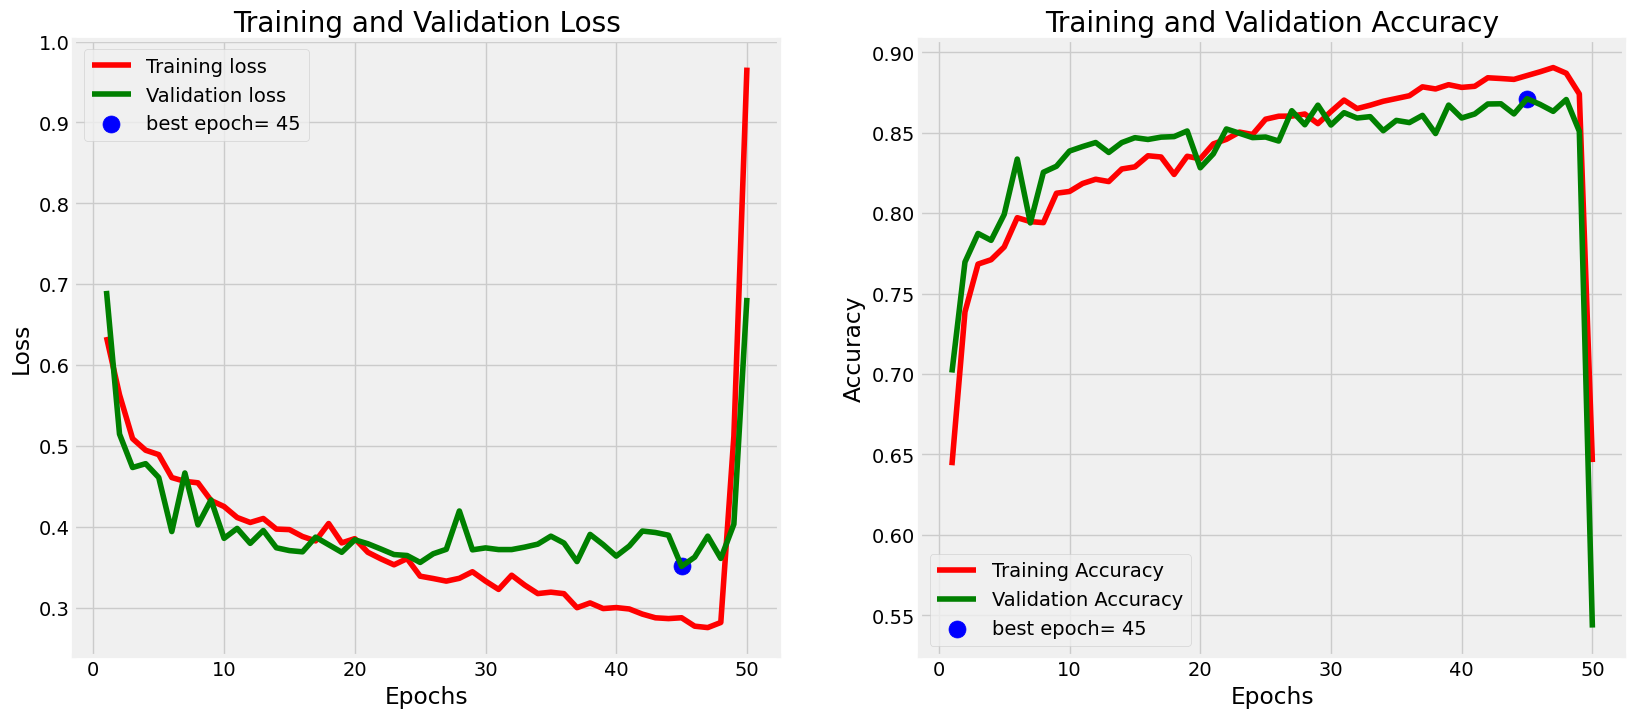

In [14]:
plot_training(results)

In [15]:
# Evaluate the model

modelUNet.evaluate(X, Y)

10/10 [==============================] - 45s 4s/step - loss: 0.6780 - accuracy: 0.5612


[0.6779612302780151, 0.561190128326416]

<Figure size 3000x3000 with 0 Axes>

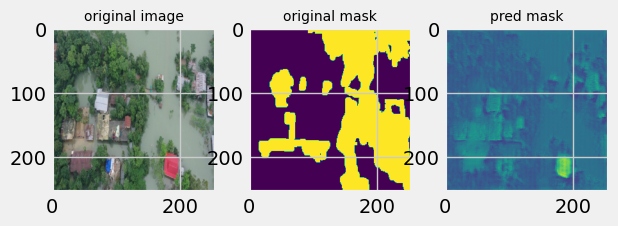

In [16]:
# displaying random image, mask, and predicted mask

plt.figure(figsize=(30,30))

ind = random.randint(0, len(X))
img = X[ind]
predMask = modelUNet.predict(np.expand_dims(img, axis=0), verbose=0)
fig = plt.figure()
ax1 = fig.add_subplot(1, 3, 1)
ax1.set_title("original image", fontdict = {'fontsize' : 10})
ax1.imshow(X[ind])
ax2 = fig.add_subplot(1, 3, 2)
ax2.set_title("original mask", fontdict = {'fontsize' : 10})
ax2.imshow(np.squeeze(Y[ind]))
ax3 = fig.add_subplot(1, 3, 3)
ax3.set_title("pred mask", fontdict = {'fontsize' : 10})
ax3.imshow(np.squeeze(predMask))

# Thank you for visiting my notebook

# If you liked it please upvote!